# Species-Specific DNA Sequence Identification Using Machine Learning
This project aims to develop and evaluate  EUGENe-based machine learning models for identifying species-specific DNA sequences, focusing on human and worm DNA. The primary goal is to build a model that can accurately classify DNA sequences as belonging to either humans or worms, ultimately contributing to the understanding of genomic differences between these species.

## Load in packages and import modules

Adam Klie (last updated: *07/08/2023*)

In [ ]:
!pip install genomic-benchmarks

In [ ]:
from genomic_benchmarks.dataset_getters.pytorch_datasets import get_dataset

In this tutorial, we illustrate a basic end-to-end EUGENe workflow that trains and interprets a single task regression model on a [published dataset of plant promoters](https://www.nature.com/articles/s41477-021-00932-y). If you are just starting out with EUGENE, you are in the right place! This tutorial will walk you through the steps of preparing the data, training a single task regression model, and interpreting that trained model.

You can also find this tutorial as a Jupyter notebook in the `docs` [directory of the EUGENE repository](https://github.com/cartercompbio/EUGENe/blob/main/docs/basic_usage_tutorial.ipynb). You can copy this notebook from there, or just copy and paste the code in each cell into a new notebook to follow along. Just make sure to have [installed EUGENe](https://eugene-tools.readthedocs.io/en/latest/installation.html) in your environment before you start!

> **Warning**:
> Before you start! Running this notebook without a GPU on this data is feasible but will be very slow. We'd recommend using [Google Colab](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) if you don't have access to your own GPU.


> **Note**:
> We've noticed that for some IDE configurations, plots do not render in a Jupyter notebook unless you include the `%matplotlib inline` magic command. If you are having trouble rendering plots, make sure you have this line in your notebook or use `plt.show()` after each plot.

In [ ]:
%matplotlib inline

In [4]:
!pip install 'eugene-tools'


  Using cached biopython-1.77-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: biopython
    Found existing installation: biopython 1.84
    Uninstalling biopython-1.84:
      Successfully uninstalled biopython-1.84
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
genomic-benchmarks 0.0.9 requires biopython>=1.79, but you have biopython 1.77 which is incompatible.


In [5]:
!pip install torchmetrics==0.11.0

In [39]:
# Imports
import os
import torch
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seqdatasets
import seqdata as sd
import xarray as xr
from eugene import preprocess as pp
from eugene.models.zoo import DeepBind, DeepSTARR
from eugene.models import SequenceModule
from eugene.models.base._metrics import calculate_metric
from eugene import plot as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
import seqdatasets
import genomic_benchmarks

## Configuring

To make it easy to keep track of all the datasets and model outputs, we'll set some directories.

In [40]:
# Change this to where you would like to save all your results
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/EUGENe")  # TODO: change this to your own directory
cwd = os.getcwd()
cwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/EUGENe'

In [41]:
# Configure EUGENe directories, if you do not set these, EUGENe will use the default directories
from eugene import settings
settings.config_dir = "./tutorial_configs" # Directory to specify when you want to load a model from a config file
settings.dataset_dir = "./tutorial_dataset" # Directory where EUGENe will download datasets to
settings.logging_dir = "./tutorial_logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
settings.output_dir = "./tutorial_output" # Directory where EUGENe will save output files to
settings.figure_dir = "./tutorial_figures" # Directory to specify to EUGENe to save figures to

## Dataloading
For this project, we'll load in a dataset consisting of 200bp-long sequences from worms and humans. Eugene uses seqdata to pre-process data, so we'll need to convert the loaded in dataset into a seqdata object. This is accomplished by first loading in the dataset from the genomic_benchmarks dataset module, then converting it to a csv file. Seqdata can directly convert csv's to seqdata objects, and we'll specify which columns hold the sequences and which hold the labels.

In [42]:
from genomic_benchmarks.data_check import list_datasets

In [43]:
# get dataset
sdata_train = get_dataset("demo_human_or_worm", split="train", version = 0)

In [44]:

# Convert training dataset to list of dictionaries
data_list = []
for i in range(len(sdata_train)):
    sample = sdata_train[i]
    data_dict = {
        'sequences': sample[0],
        'target': sample[1],
    }
    data_list.append(data_dict)

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_list)
print(df)
# convert DataFrame to csv
df.to_csv('worm_human_sequences_train.csv', index=False)



                                               sequences  target
0      TCTCTCAAAAGGTTACTACCAGTGCAGGAGAATTTTCTTCTTAAAT...       0
1      ACCCACAGAATGGGAGAAAATCTTCACAAACTATGCATCCAACAAA...       0
2      AGTTCCTCTGATGGAGCCACATCCACTCAAGTCCAGCCTAGCCCAA...       0
3      TGATTTTAAGAATTAAATGCTGATTCCATAAAATTTAATATTTATT...       0
4      TTTTTCTTTCTCCTTTCCTTTCCTCCCCTCCTCCCTTTCTCTCTCT...       0
...                                                  ...     ...
74995  ATAAAAATGGGAACAAGCCGTCACTTCAACGCAACAAACACTTCTT...       1
74996  CCCAAATGATGTTCATATGTTTTTCAAAGTGAAACAATTGATAATT...       1
74997  TAACGACGTTGTTTGGAAAAACTATGGTTCAGTAACTTCTGATCTT...       1
74998  AAGGCTTGTTTAATTAGGAGAAAATGTATCTTAATTAGAGCAAATC...       1
74999  AAATCATACGGTTTGAATGAAAAGATCTTTGGGCTTTTCTGTTGAT...       1

[75000 rows x 2 columns]


Finally, we'll convert the datasets to a seqdata objects

In [45]:
sdata = sd.read_table(name="seq", out="human_worm_train.zarr", tables='worm_human_sequences_train.csv', seq_col="sequences", batch_size=10000, fixed_length=True, overwrite=True)

75000it [00:00, 107820.36it/s]


Next, we need to one-hot encode the sequence data for processing by our models, and then split the sequences into test and train sets.

In [46]:

# One hot encode sequences
pp.ohe_seqs_sdata(sdata)

# Give unique identifers
pp.make_unique_ids_sdata(sdata)

# Split data into test and train sets
pp.train_test_random_split(sdata, dim="_sequence", test_size=(0.2))
sdata["ohe_seq"] = sdata["ohe_seq"].transpose("_sequence", "_ohe", "length")
sdata



# Set-up target
sdata["target"] = sdata["target"].load()



# Split into train and val
train_mask = np.where(sdata["train_val"])[0]
train_sdata = sdata.isel(_sequence=train_mask)
train_dataloader = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    #transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=True,
    drop_last=True,
    batch_size=128
)
val_sdata = sdata.isel(_sequence=~train_mask)
val_dataloader = sd.get_torch_dataloader(
    val_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    #transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=False,
    drop_last=True,
    batch_size=128
)

##First Model
Now we're ready to start training our first model! DeepBind is a very simple deep convolutional neural network (CNN) developed for predicting the sequence specificities of DNA- and RNA- binding proteins. With a few tweaks we can have it perform binary classification on our worm/human sequence data.


In [47]:

# Specify the architecture of our model and the input length/output dimension
arch = DeepBind(
    input_len=200, # 200 bp long sequences
    output_dim=1 # Binary calssification (predict 0 or 1)
)



Here we're going to wrap our model in EUGENe's SequenceModule function, specifying that we want the DeepBind model to perform binary classification, along with a few other parameters that will help us get more accurate predictions.

In [48]:

# Wrap the architecture in a SequenceModule to allow for easy training
model = SequenceModule(
    arch=arch,
    task="binary_classification",
    arch_name="DeepBind",
    model_name="worm_human_DeepBind_regression",
    scheduler="reduce_lr_on_plateau",
    metric="accuracy",
    metric_kwargs={"task": "binary"}
)
model.summary()


Model: DeepBind
Sequence length: 200
Output dimension: 1
Task: binary_classification
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {}
Metric: accuracy
	Metric parameters: {'task': 'binary'}
Seed: None
Parameters summary:


  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | arch         | DeepBind       | 2.1 K  | train
1 | train_metric | BinaryAccuracy | 0      | train
2 | val_metric   | BinaryAccuracy | 0      | train
3 | test_metric  | BinaryAccuracy | 0      | train
--------------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode

Next we're going to build our trainer, metric logger, and callbacks. These are all based off of EUGENe tutorial noteboooks.

In [49]:


# Set-up a logger so we can track training progress
logger = TensorBoardLogger(
    save_dir="/cellar/users/aklie/projects/ML4GLand/EUGENe/notebooks/tests",
    name="human_worm_DeepBind_regression",
    version="0.0.1"
)




In [50]:


# Set-up a trainer to train the model on
callbacks = []
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints"),
    save_top_k=3,
    monitor="val_loss_epoch"
)
callbacks.append(model_checkpoint_callback)
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=10,
    mode="min",
    verbose=False,
)
callbacks.append(early_stopping_callback)
if model.scheduler is not None:
    callbacks.append(LearningRateMonitor())
trainer = Trainer(
    max_epochs=15,
    logger=logger,
    devices=1,
    accelerator="auto",
    callbacks=callbacks,
    log_every_n_steps=10
)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Now it's time to train! The trainer.fit function will implement all the training functions we just created to train our model on the worm_human dataset.

In [51]:

# Fit the model to the data
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)




/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /cellar/users/aklie/projects/ML4GLand/EUGENe/notebooks/tests/human_worm_DeepBind_regression/0.0.1/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | arch         | DeepBind       | 2.1 K  | train
1 | train_metric | BinaryAccuracy | 0      | train
2 | val_metric   | BinaryAccuracy | 0      | train
3 | test_metric  | BinaryAccuracy | 0      | train
--------------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In order to see how our model did, we can plot the training loss and validation loss over the epochs. We can also visualize the accuracy of the model using the logged metric.

/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)


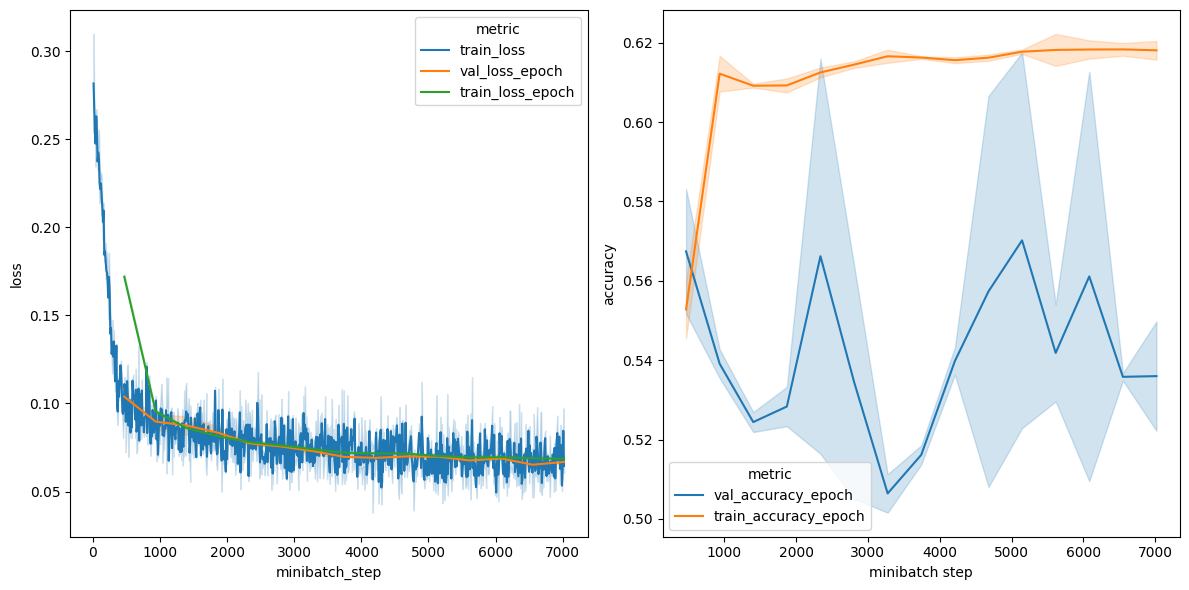

In [52]:

pl.training_summary(os.path.join(logger.save_dir, logger.name, logger.version), metric="accuracy")


We did pretty good! We got an accuracy of over 95%, which is quite good for the short sequences we provided it.

## Second Model
That worked really well! But what if we made our own model, instead of using a pre-trained model like DeepBind? Here we make a very simple CNN model (similarly structured to DeepBind but with less layers) and set up the same dataloaders and training functions as before.

In [53]:
# Creating Small CNN Model

import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self):  # define layers
        super(SmallCNN, self).__init__()

        # Set the attributes
        self.input_len = 200
        self.output_dim = 1

        # Create the blocks
        self.conv1 = nn.Conv1d(4, 30, 21)
        self.relu  = nn.ReLU()

        self.dense = nn.Linear(30, 1)

    def forward(self, x):  # define how inputs are propagated through those layers
        x = self.conv1(x)
        x = self.relu(x)
        x = F.max_pool1d(x, x.size()[-1]).flatten(1, -1)
        x = self.dense(x)
        return x

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/EUGENe/SmallCNN_binary/0.0.1/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | arch         | SmallCNN       | 2.6 K  | train
1 | train_metric | BinaryAccuracy | 0      | train
2 | val_metric   | BinaryAccuracy | 0      | train
3 | test_metric  | BinaryAccuracy | 0      | train
--------------------------------------------------------
2.6 K     Trainable params
0         Non-trainable p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_

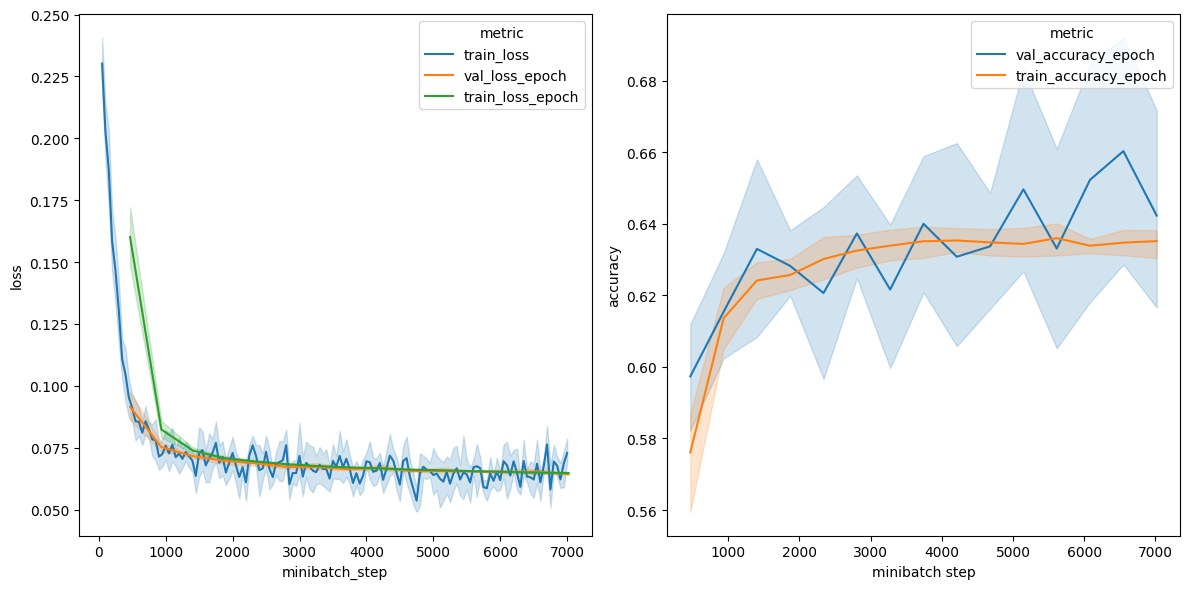

In [54]:
from eugene import models

# Wrap the architecture in a SequenceModule to allow for easy training
model = SequenceModule(
    arch=SmallCNN(),
    task="binary_classification",
    arch_name="SmallCNN",
    model_name="SmallCNN_binary",
    scheduler="reduce_lr_on_plateau",
    metric="accuracy",
    metric_kwargs={"task": "binary"}
)

# Set-up a logger so we can track training progress
logger = TensorBoardLogger(
    save_dir=cwd,
    name="SmallCNN_binary",
    version="0.0.1"
)


# Set-up a trainer
callbacks = []
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints"),
    save_top_k=3,
    monitor="val_loss_epoch"
)
callbacks.append(model_checkpoint_callback)
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=3,
    mode="min",
    verbose=False,
)
callbacks.append(early_stopping_callback)
if model.scheduler is not None:
    callbacks.append(LearningRateMonitor())
trainer = Trainer(
    max_epochs=15,
    logger=logger,
    devices=1,
    accelerator="auto",
    callbacks=callbacks,
    fast_dev_run=False,
    num_sanity_val_steps=1
)


# Re-initialize weights before training
models.init_weights(SmallCNN())

# Fit the model to the data
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

# Visualize the training progress
pl.training_summary(os.path.join(logger.save_dir, logger.name, logger.version), metric="accuracy")


The model performed significantly worse compared to the DeepBind model, which makes sense considering how much smaller it is.

## Third Model
What happens if we add more layers? Let's try making a much larger CNN ourselves and see how it compares to the pre-trained DeepBind CNN.

In [55]:
# Define model

import torch
import torch.nn as nn
class IanCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Set the attributes
        self.input_len = 200  # Sequence length
        self.output_dim = 1  # Binary classification

        # Convolutional layers
        self.conv1 = nn.Conv1d(4, 128, kernel_size=13)
        self.bn1 = nn.BatchNorm1d(128)

        self.conv2 = nn.Conv1d(128, 128, kernel_size=13)
        self.bn2 = nn.BatchNorm1d(128)

        # Dropout layer (Drop 50% of neurons during training)
        self.dropout_conv = nn.Dropout(p=0.4)  # Dropout for convolutional layers
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout for fully connected layers

        # Max Pooling and Global Average Pooling
        self.pool = nn.MaxPool1d(kernel_size=2, stride=1)
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling

        # Fully connected layers
        self.fc1 = nn.Linear(128, 128)  # First fully connected layer
        self.bn_fc1 = nn.BatchNorm1d(128)  # Batch normalization
        self.fc2 = nn.Linear(128, 128)  # Second fully connected layer
        self.bn_fc2 = nn.BatchNorm1d(128)  # Batch normalization
        self.fc3 = nn.Linear(128, self.output_dim)  # Final output layer
        self.sigmoid = nn.Sigmoid() # Add sigmoid activation



    def forward(self, x):
        # First convolutional layer
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.bn1(x)  # Apply batch normalization
        x = self.dropout_conv(x)  # Apply dropout


        # Second convolutional layer
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.bn2(x)  # Apply batch normalization
        x = self.dropout_conv(x)  # Apply dropout

        # Global average pooling to reduce the output size
        x = self.global_pool(x)  # Shape becomes (batch_size, 1024, 1)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 1024)

        # First fully connected layer
        x = torch.relu(self.fc1(x))
        x = self.bn_fc1(x)  # Apply batch normalization
        x = self.dropout_fc(x)  # Apply dropout

        # Second fully connected layer
        x = torch.relu(self.fc2(x))
        x = self.bn_fc2(x)  # Apply batch normalization
        x = self.dropout_fc(x)  # Apply dropout


        # Final output layer
        x = self.fc3(x)
        x = self.sigmoid(x) # Apply sigmoid activation


        return x



In [56]:
# Set the architecture as the model we just made
arch = IanCNN()


# Wrap the architecture in a SequenceModule to allow for easy training
model = SequenceModule(
    arch=arch,
    task="binary_classification",
    arch_name="IanCNN",
    model_name="IanCNN_regression",
    scheduler="reduce_lr_on_plateau",
    loss_fxn=nn.BCEWithLogitsLoss(),
    metric="accuracy",
    metric_kwargs={"task": "binary"}


)



# Set-up a logger so we can track training progress
logger = TensorBoardLogger(
    save_dir="/cellar/users/aklie/projects/ML4GLand/EUGENe/notebooks/tests",
    name="IanCNN_binary_classification",
    version="0.0.1"
)

# Set-up a trainer.
callbacks = []
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints"),
    save_top_k=3,
    monitor="val_loss_epoch"
)
callbacks.append(model_checkpoint_callback)
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=3,
    mode="min",
    verbose=False,
)
callbacks.append(early_stopping_callback)
if model.scheduler is not None:
    callbacks.append(LearningRateMonitor())
trainer = Trainer(
    max_epochs=5,
    logger=logger,
    devices=1,
    accelerator="auto",
    callbacks=callbacks,
)


# Fit the model to the data
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'loss_fxn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fxn'])`.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /cellar/users/aklie/projects/ML4GLand/EUGENe/notebooks/tests/IanCNN_binary_classification/0.0.1/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
--------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [57]:
from eugene import plot as pl

/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)


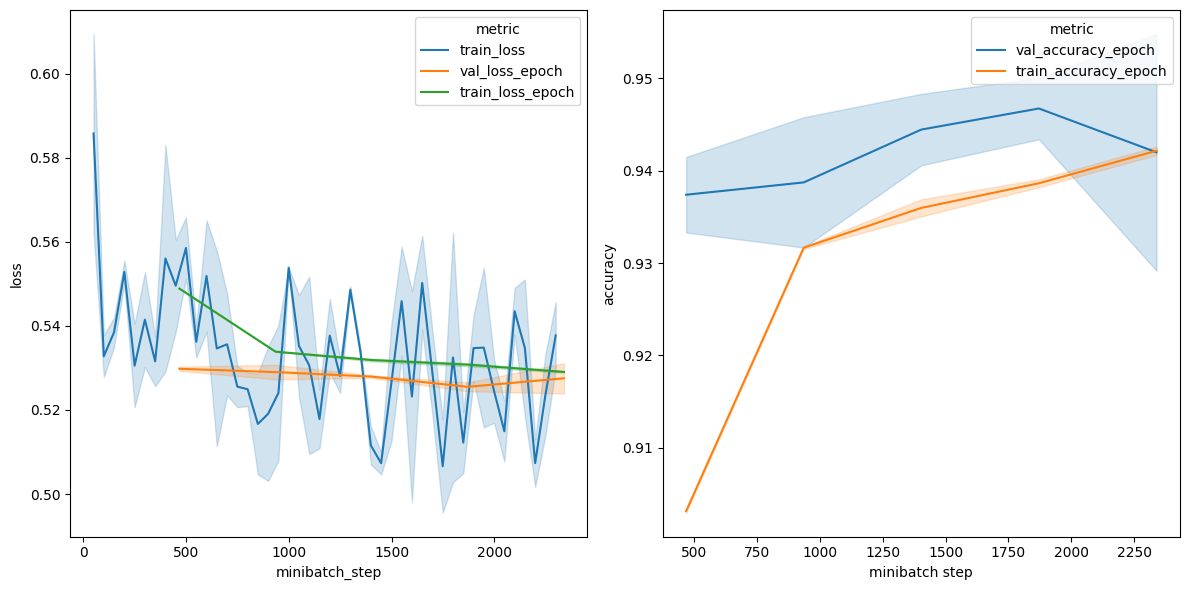

In [58]:
pl.training_summary(os.path.join(logger.save_dir, logger.name, logger.version), metric="accuracy")


Nice! By making our CNN larger we achieved almost the same level of accuracy as the DeepBind CNN!

## IanCNN Interpretation
Now that we have a well-performing model, let's try to understand what it's really doing to determine whether the sequence comes from a worm or a human.

### Filter interpretation
We can directly see what each filter of the first convolutional layer of IanCNN is picking up on by using the following functions. These create a position frequency matrix for each filter in the model using sequences that highly activate that filter

In [59]:
from eugene import interpret

In [60]:
interpret.generate_pfms_sdata(
    model,
    sdata,
    seq_var="ohe_seq",
    layer_name="arch.conv1",
    kernel_size=13,
    num_filters=32,
    num_seqlets=100,
)

Getting activations on batches of size 128:   0%|          | 0/586 [00:00<?, ?it/s]

Getting filter activators for 32 filters:   0%|          | 0/32 [00:00<?, ?it/s]

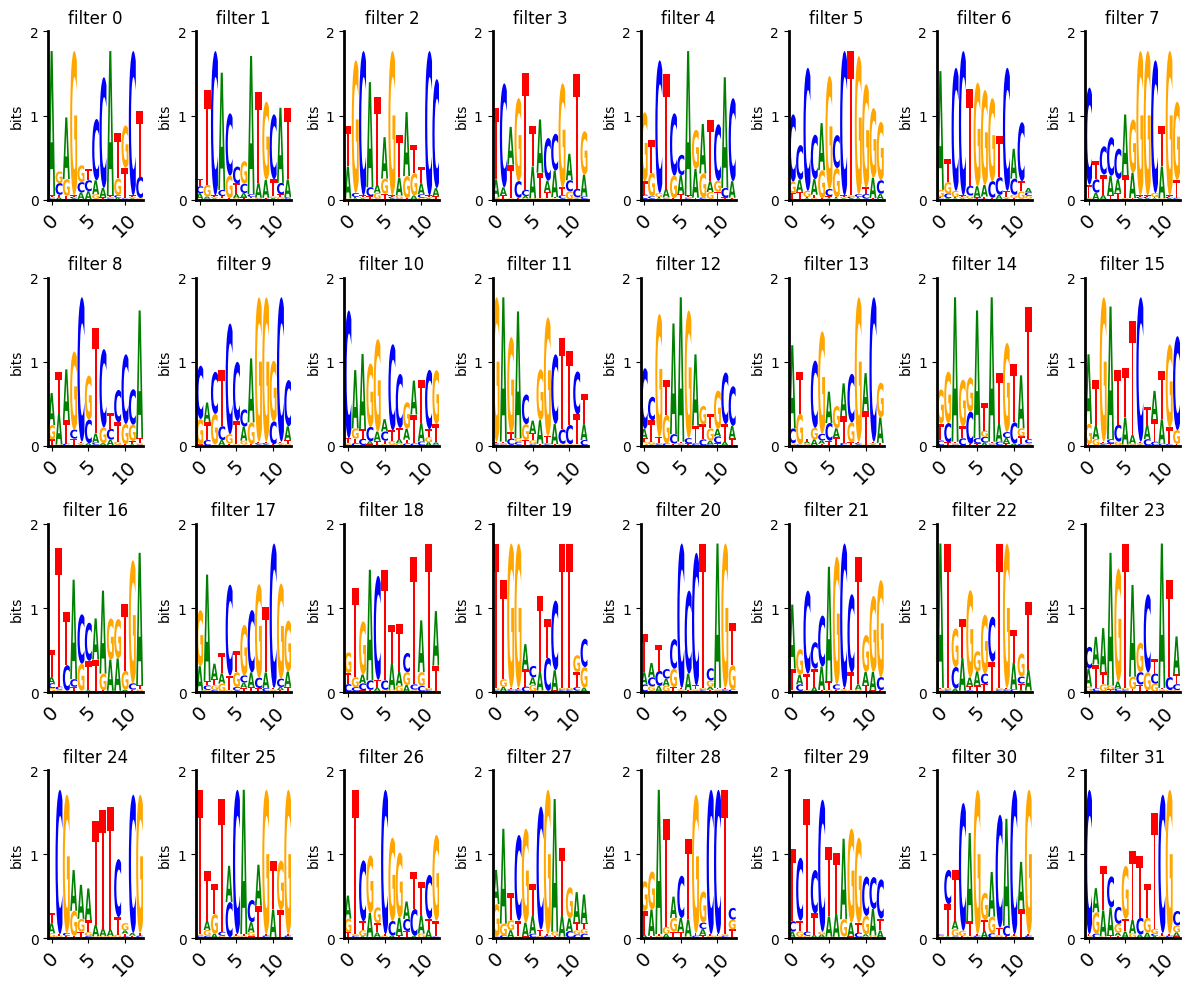

In [61]:
# We can visualize these PFMs as PWM logos
pl.multifilter_viz(
    sdata,
    filter_nums=range(0, 32),
    pfms_var="arch.conv1_pfms",
    num_rows=4,
    num_cols=8,
    titles=[f"filter {i}" for i in range(0, 32)],
)

In [62]:
interpret.filters_to_meme_sdata(
    sdata,
    filters_var="arch.conv1_pfms",
    axis_order=("_arch.conv1_32_filters", "_ohe", "_arch.conv1_13_kernel_size"),
    output_dir=os.path.join(settings.output_dir),
    filename="IanCNN_model_filters.meme"
)

Output directory already exists: /content/drive/MyDrive/EUGENe/tutorial_output
Saved pfm in MEME format as: /content/drive/MyDrive/EUGENe/tutorial_output/IanCNN_model_filters.meme


### Attribution analysis
We can also perform attribution analysis, where we can quantifty the contirbution of each nucelotide to the models predictions for that sequence.

In [63]:
from eugene import evaluate

# Make some predictions based on the validation set
evaluate.predictions_sequence_module(
    model,
    sdata=val_sdata,
    seq_var="ohe_seq",
    target_vars=["target"],
    batch_size=128,
    in_memory=True,
    name="IanCNN",
    version="IanCNN_model",
    file_label="test",
    prefix=f"IanCNN_model_",
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading ohe_seq and ['target'] into memory


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [64]:
interpret.attribute_sdata(
    model,
    val_sdata,
    batch_size=128,
    #transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Computing saliency on batches of size 128:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/seqexplainer/attributions/_attributions.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_ = torch.tensor(inputs_, dtype=torch.float32).requires_grad_(True).to(device)


We can then visualize these importance scores using a sequence logo plot. Here we show the results on the sequences with the highest predicted activity by our model.

Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

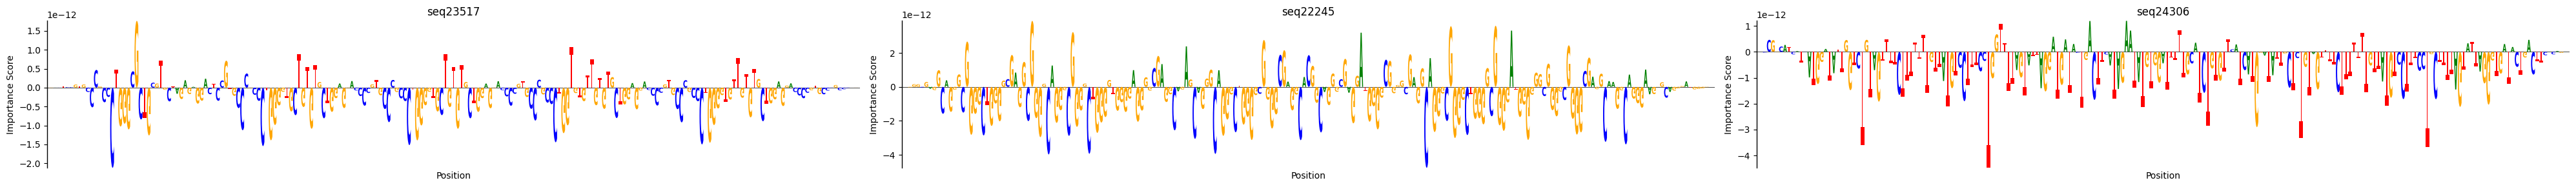

In [65]:
# Grab the top3 in terms of predictions to plot tracks for
top3 = val_sdata["IanCNN_model_target_predictions"].to_series().sort_values(ascending=True).iloc[:3].index
ids = val_sdata["id"].values[top3]
pl.multiseq_track(
    val_sdata,
    seq_ids=ids,
    attrs_vars= "InputXGradient_attrs",
    height=3,
    width=40,
)

### Global importance analysis (GIA)
The last interpretation method we'll perform is global importance analysis. We feed it sequences that we design ourselves and compare that to a baseline set of predictions. Here we'll feed it a TATA box motif, which is present in both humans and worms.

We first need some background sequences to establish baseline predictions. Here we use the SeqPro subpackage to generate 5 random sequences and make our own SeqData object from scratch

In [66]:
# Import the packages
import seqpro as sp
import xarray as xr

In [106]:
# Create an SeqData object so its compatible with the function
random_ohe_seq = sp.ohe(sp.random_seqs((10, 200), sp.alphabets.DNA), sp.alphabets.DNA).swapaxes(1, 2)
sdata_random = xr.Dataset({"ohe_seq": (("_sequence", "_ohe", "length"), random_ohe_seq)})
pp.make_unique_ids_sdata(sdata_random, id_var="name")


In [107]:
# Let's get our background predictions
sdata_random["background_predictions"] = model.predict(sdata_random["ohe_seq"].values).squeeze()

Predicting on batches: 0it [00:00, ?it/s]

In [108]:
print(sdata_random["background_predictions"])

<xarray.DataArray 'background_predictions' (background_predictions: 10)>
array([1.      , 0.999616, 1.      , 0.9731  , 0.999995, 0.999994, 0.999999,
       1.      , 0.999999, 0.766797], dtype=float32)
Coordinates:
  * background_predictions  (background_predictions) float32 1.0 ... 0.7668


To handle the motif, we will use the MotifData subpackage in EUGENe.

In [109]:
import motifdata as md

In [70]:
# TODO: The motif can be downlaoded from https://github.com/tobjores/Synthetic-Promoter-Designs-Enabled-by-a-Comprehensive-Analysis-of-Plant-Core-Promoters/blob/main/data/misc
!wget https://raw.githubusercontent.com/tobjores/Synthetic-Promoter-Designs-Enabled-by-a-Comprehensive-Analysis-of-Plant-Core-Promoters/main/data/misc/CPEs.meme -O $cwd/tutorial_dataset/CPEs.meme

--2024-12-06 17:26:09--  https://raw.githubusercontent.com/tobjores/Synthetic-Promoter-Designs-Enabled-by-a-Comprehensive-Analysis-of-Plant-Core-Promoters/main/data/misc/CPEs.meme
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2913 (2.8K) [text/plain]
Saving to: ‘/content/drive/MyDrive/EUGENe/tutorial_dataset/CPEs.meme’

/content/drive/MyDr 100%[===================>]   2.84K  --.-KB/s    in 0s      

2024-12-06 17:26:09 (14.4 MB/s) - ‘/content/drive/MyDrive/EUGENe/tutorial_dataset/CPEs.meme’ saved [2913/2913]



In [110]:
# We can load it and pull out the PFM and other info about the motif
meme = md.read_meme(os.path.join(settings.dataset_dir, "MA0154.4.meme"))
print(meme.motifs)
motif = meme.motifs["MA0154.4"]
feat_name = motif.name
pfm = motif.pfm
consensus = motif.consensus
consensus_ohe = sp.ohe(consensus, alphabet=sp.alphabets.DNA)
feat_name, pfm, consensus

{'MA0154.4': Motif MA0154.4 (EBF1) with 15 positions}


('EBF1',
 array([[0.311723, 0.195223, 0.239758, 0.253297],
        [0.251029, 0.210325, 0.296775, 0.241871],
        [0.051778, 0.099196, 0.121013, 0.728013],
        [0.029081, 0.763126, 0.042267, 0.165526],
        [0.012504, 0.952251, 0.008167, 0.027078],
        [0.014265, 0.936973, 0.009752, 0.039009],
        [0.055894, 0.873418, 0.018976, 0.051712],
        [0.764887, 0.037578, 0.037931, 0.159604],
        [0.077094, 0.01792 , 0.85257 , 0.052416],
        [0.057611, 0.010897, 0.916918, 0.014573],
        [0.033352, 0.010017, 0.94197 , 0.014662],
        [0.194959, 0.054199, 0.721211, 0.029631],
        [0.696445, 0.139901, 0.109125, 0.054529],
        [0.247199, 0.292768, 0.216951, 0.243082],
        [0.262036, 0.238547, 0.201937, 0.297479]]),
 'AGTCCCCAGGGGACT')

Now that we have a feature, we can implant it at every possible position of the input sequence and see what that does to model predictions.

In [111]:
# This is the EUGENe function that does exactly that!
interpret.positional_gia_sdata(
    model=model,
    sdata=sdata_random,
    feature=consensus_ohe,
    id_var="name",
    store_var=f"slide_{feat_name}",
    encoding="onehot"
)

Implanting feature in all seqs of sdata:   0%|          | 0/10 [00:00<?, ?it/s]

Next we can visualize the results as a line plot using a custom function from the `plot` module.

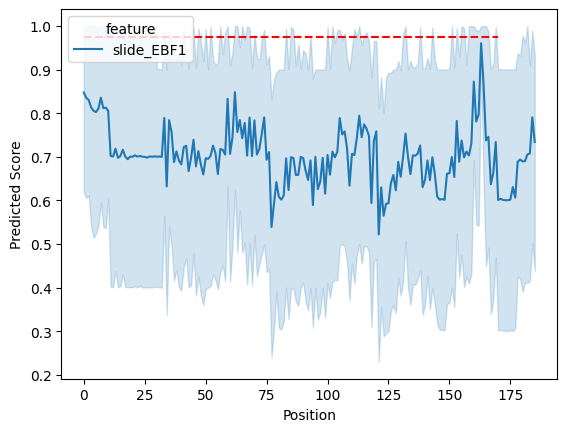

In [112]:
ax = pl.positional_gia_plot(sdata_random,keys=[f"slide_{feat_name}"], id_var="name", return_axes=True)
ax.hlines(sdata_random["background_predictions"].mean(), 0, 170, linestyle="--", color="red")

---